# News dataset

In [3]:
%pip install google-cloud-bigquery pandas db-dtypes google-auth

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from google.cloud import bigquery
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

# Parameters
YEAR = 2024
FINAL_EVENTS_FILE = f"gdelt_events_clean_{YEAR}.csv"
PROJECT_ID = os.getenv("PROJECT_ID", "")

# Event columns we need
COLUMN_NAMES = [
    "GLOBALEVENTID", "SQLDATE", "Actor1CountryCode", "ActionGeo_FullName",
    "ActionGeo_Lat", "ActionGeo_Long", "EventRootCode", "GoldsteinScale",
    "NumMentions", "NumSources", "AvgTone"
]

KEYWORDS = [
    "port", "harbour", "harbor", "terminal", "shipment", "logistics",
    "container", "freight", "cargo", "vessel", "maritime", "supply",
    "trade", "import", "export", "customs", "sanction", "blockade",
    "strike", "riot", "protest", "labor", "labour", "disruption",
    "storm", "hurricane", "typhoon", "flood", "earthquake", "covid",
    "pandemic", "lockdown", "weather", "cyclone"
]

print("=" * 80)
print("GDELT DATA DOWNLOAD VIA GOOGLE BIGQUERY")
print("=" * 80)

# Initialize BigQuery client (uses anonymous public access)
print("\n🔧 Initializing BigQuery client...")
os.environ["GCLOUD_PROJECT"] = PROJECT_ID
client = bigquery.Client(project=PROJECT_ID)

# Build keyword filter for SQL
keyword_conditions = " OR ".join([
    f"LOWER(ActionGeo_FullName) LIKE '%{kw.lower()}%'" 
    for kw in KEYWORDS
])

# BigQuery SQL to fetch maritime supply chain disruption events for 2020
query = f"""
SELECT 
    GLOBALEVENTID,
    SQLDATE,
    Actor1CountryCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    EventRootCode,
    GoldsteinScale,
    NumMentions,
    NumSources,
    AvgTone
FROM 
    `gdelt-bq.gdeltv2.events`
WHERE 
    SQLDATE >= {YEAR}0101 
    AND SQLDATE <= {YEAR}1231
    AND ActionGeo_FullName IS NOT NULL
    AND ({keyword_conditions})
    AND ActionGeo_Lat IS NOT NULL
    AND ActionGeo_Long IS NOT NULL
ORDER BY 
    SQLDATE
"""

print(f"\n📊 Querying GDELT BigQuery for {YEAR} maritime events...")
print(f"   Date range: {YEAR}-01-01 to {YEAR}-12-31")
print(f"   Filtering: {len(KEYWORDS)} supply chain keywords")
print(f"   This may take 2-5 minutes depending on data size...\n")

try:
    # Execute query
    query_job = client.query(query)
    
    # Fetch results with progress bar
    print("⏳ Executing query and fetching results...")
    events_df = query_job.to_dataframe(progress_bar_type='tqdm')
    
    if len(events_df) == 0:
        print("❌ No events found! Check your BigQuery access or filters.")
    else:
        # Data processing
        print(f"\n✅ Retrieved {len(events_df):,} events from BigQuery")
        
        # Convert date field
        events_df["Date"] = pd.to_datetime(events_df["SQLDATE"], format="%Y%m%d")
        
        # Convert numeric fields
        numeric_cols = ["ActionGeo_Lat", "ActionGeo_Long", "GoldsteinScale", 
                       "NumMentions", "NumSources", "AvgTone"]
        for col in numeric_cols:
            events_df[col] = pd.to_numeric(events_df[col], errors='coerce')
        
        # Remove rows with missing critical data
        events_df = events_df.dropna(subset=["ActionGeo_Lat", "ActionGeo_Long", "GoldsteinScale"])
        
        print(f"   After cleaning: {len(events_df):,} events")
        print(f"   Date range: {events_df['Date'].min()} to {events_df['Date'].max()}")
        print(f"   Countries: {events_df['Actor1CountryCode'].nunique()}")
        print(f"   Locations: {events_df['ActionGeo_FullName'].nunique()}")
        
        # Save cleaned events file
        events_df.to_csv(FINAL_EVENTS_FILE, index=False)
        print(f"\n✅ Saved to: {FINAL_EVENTS_FILE}")
        print(f"   File size: {os.path.getsize(FINAL_EVENTS_FILE) / (1024*1024):.2f} MB")
        
        # Display sample data
        print("\n📋 Sample events (first 5 rows):")
        print(events_df[["Date", "Actor1CountryCode", "ActionGeo_FullName", 
                        "GoldsteinScale", "NumMentions"]].head())
        
        print("\n" + "=" * 80)
        print("🎉 GDELT DATA DOWNLOAD COMPLETE!")
        print("=" * 80)
        print(f"\n📁 Output file:")
        print(f"   {FINAL_EVENTS_FILE} - Detailed event-level data")
        print(f"\n✅ Ready to merge with AIS data for model training!")

except Exception as e:
    print(f"\n❌ BigQuery Error: {e}")
    print("\n💡 TROUBLESHOOTING:")
    print("   1. Install package: pip install google-cloud-bigquery pandas db-dtypes")
    print("   2. BigQuery uses anonymous public access for GDELT")
    print("   3. If quota exceeded, try the synthetic data approach (option 3)")
    print("   4. Check internet connection")

GDELT DATA DOWNLOAD VIA GOOGLE BIGQUERY

🔧 Initializing BigQuery client...

📊 Querying GDELT BigQuery for 2024 maritime events...
   Date range: 2024-01-01 to 2024-12-31
   Filtering: 34 supply chain keywords
   This may take 2-5 minutes depending on data size...

⏳ Executing query and fetching results...
Job ID 042d3576-b830-431e-96ec-be6cf42198a9 successfully executed: 100%|██████████|

c:\Users\EE HANN\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|

✅ Retrieved 466,495 events from BigQuery
   After cleaning: 466,495 events
   Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
   Countries: 213
   Locations: 4427

✅ Saved to: gdelt_events_clean_2024.csv
   File size: 48.83 MB

📋 Sample events (first 5 rows):
        Date Actor1CountryCode                          ActionGeo_FullName  \
0 2024-01-01               AUS  Port Macquarie, New South Wales, Australia   
1 2024-01-01              None  Port Macquarie, New South Wales, Australia   
2 2024-01-01               AUS    Shellharbour, New South Wales, Australia   
3 2024-01-01              None    Port Hacking, New South Wales, Australia   
4 2024-01-01               USA             Portland, Oregon, United States   

   GoldsteinScale  NumMentions  
0             6.0            4  
1             6.0            4  
2             3.4            3  
3             3.0           10  
4            -4.4           10  

🎉 GDELT DATA DOWNLOAD COMPLETE!



GDELT NEWS DATA EXPLORATION - 2024
📁 Output folder: graphical analysis/news_data

📊 Dataset Overview:
   Total events: 466,495
   Date range: 2024-01-01 to 2024-12-31
   Time span: 365 days

1. BASIC STATISTICS

📋 Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466495 entries, 0 to 466494
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   GLOBALEVENTID       466495 non-null  int64         
 1   SQLDATE             466495 non-null  int64         
 2   Actor1CountryCode   235124 non-null  object        
 3   ActionGeo_FullName  466495 non-null  object        
 4   ActionGeo_Lat       466495 non-null  float64       
 5   ActionGeo_Long      466495 non-null  float64       
 6   EventRootCode       466495 non-null  int64         
 7   GoldsteinScale      466495 non-null  float64       
 8   NumMentions         466495 non-null  int64         
 9   NumSources          466495 

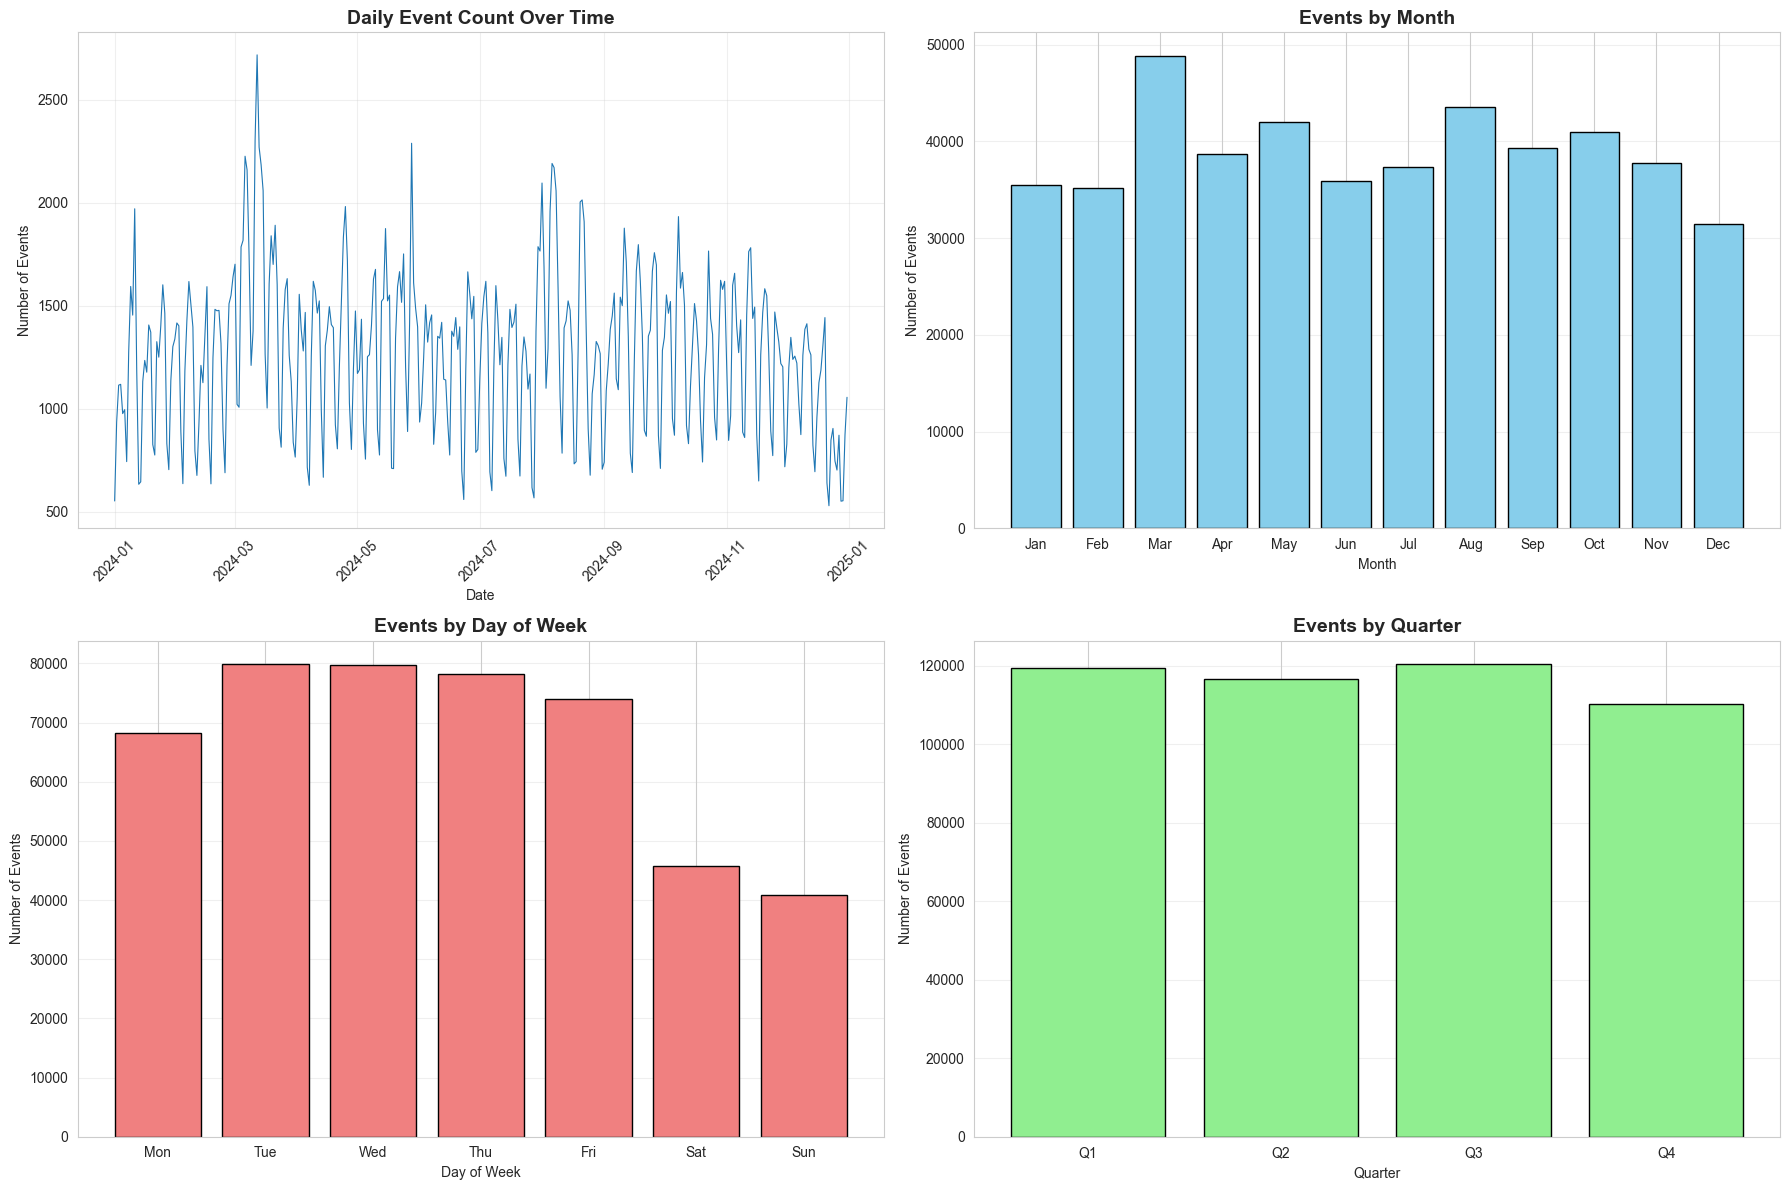


📈 Temporal Statistics:
   Busiest month: 3 (48,821 events)
   Quietest month: 12 (31,430 events)
   Busiest day: Tuesday (79,836 events)
   Average events/day: 1274.6

3. EVENT SENTIMENT ANALYSIS (GOLDSTEIN SCALE)


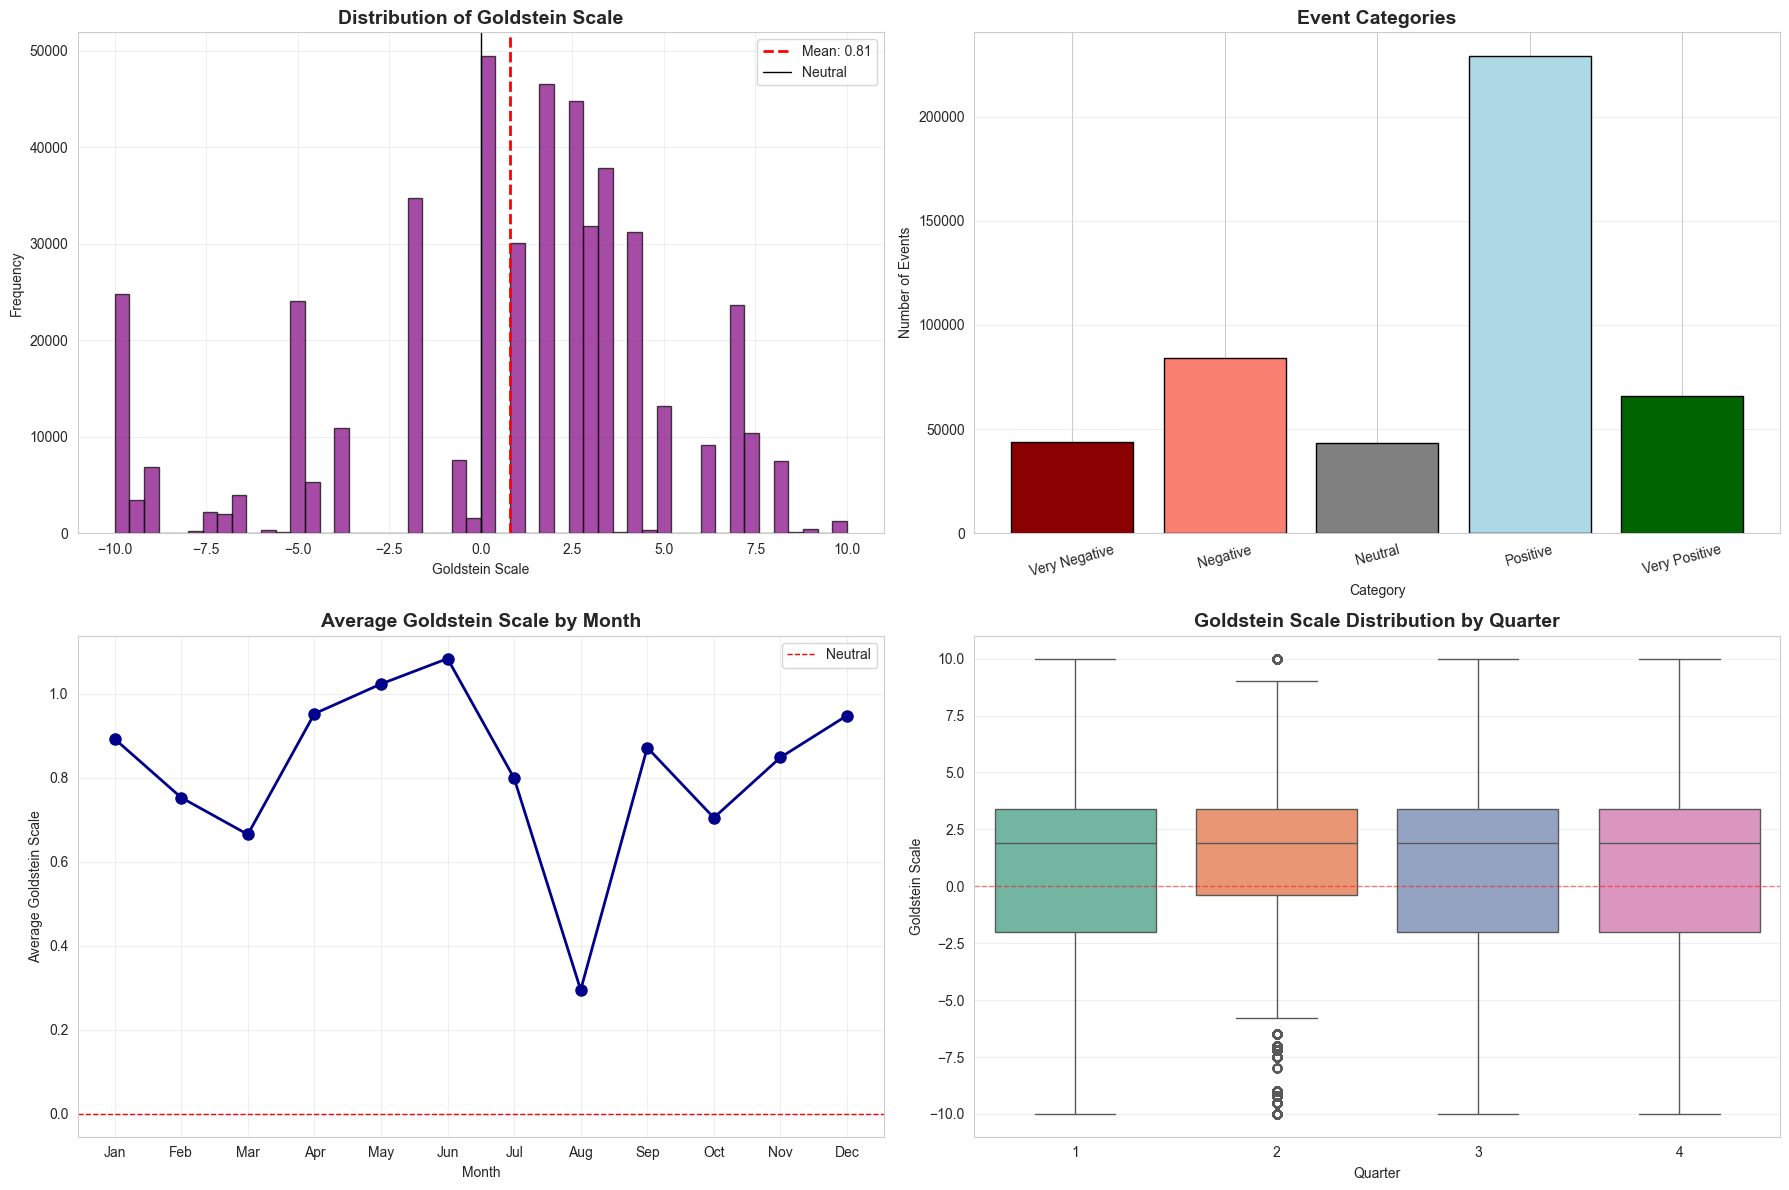


📊 Sentiment Statistics:
   Mean Goldstein: 0.809
   Median Goldstein: 1.900
   Std Dev: 4.474
   Range: [-10.00, 10.00]

   Negative events: 128,345 (27.5%)
   Neutral events: 43,429 (9.3%)
   Positive events: 294,721 (63.2%)

4. GEOGRAPHIC DISTRIBUTION


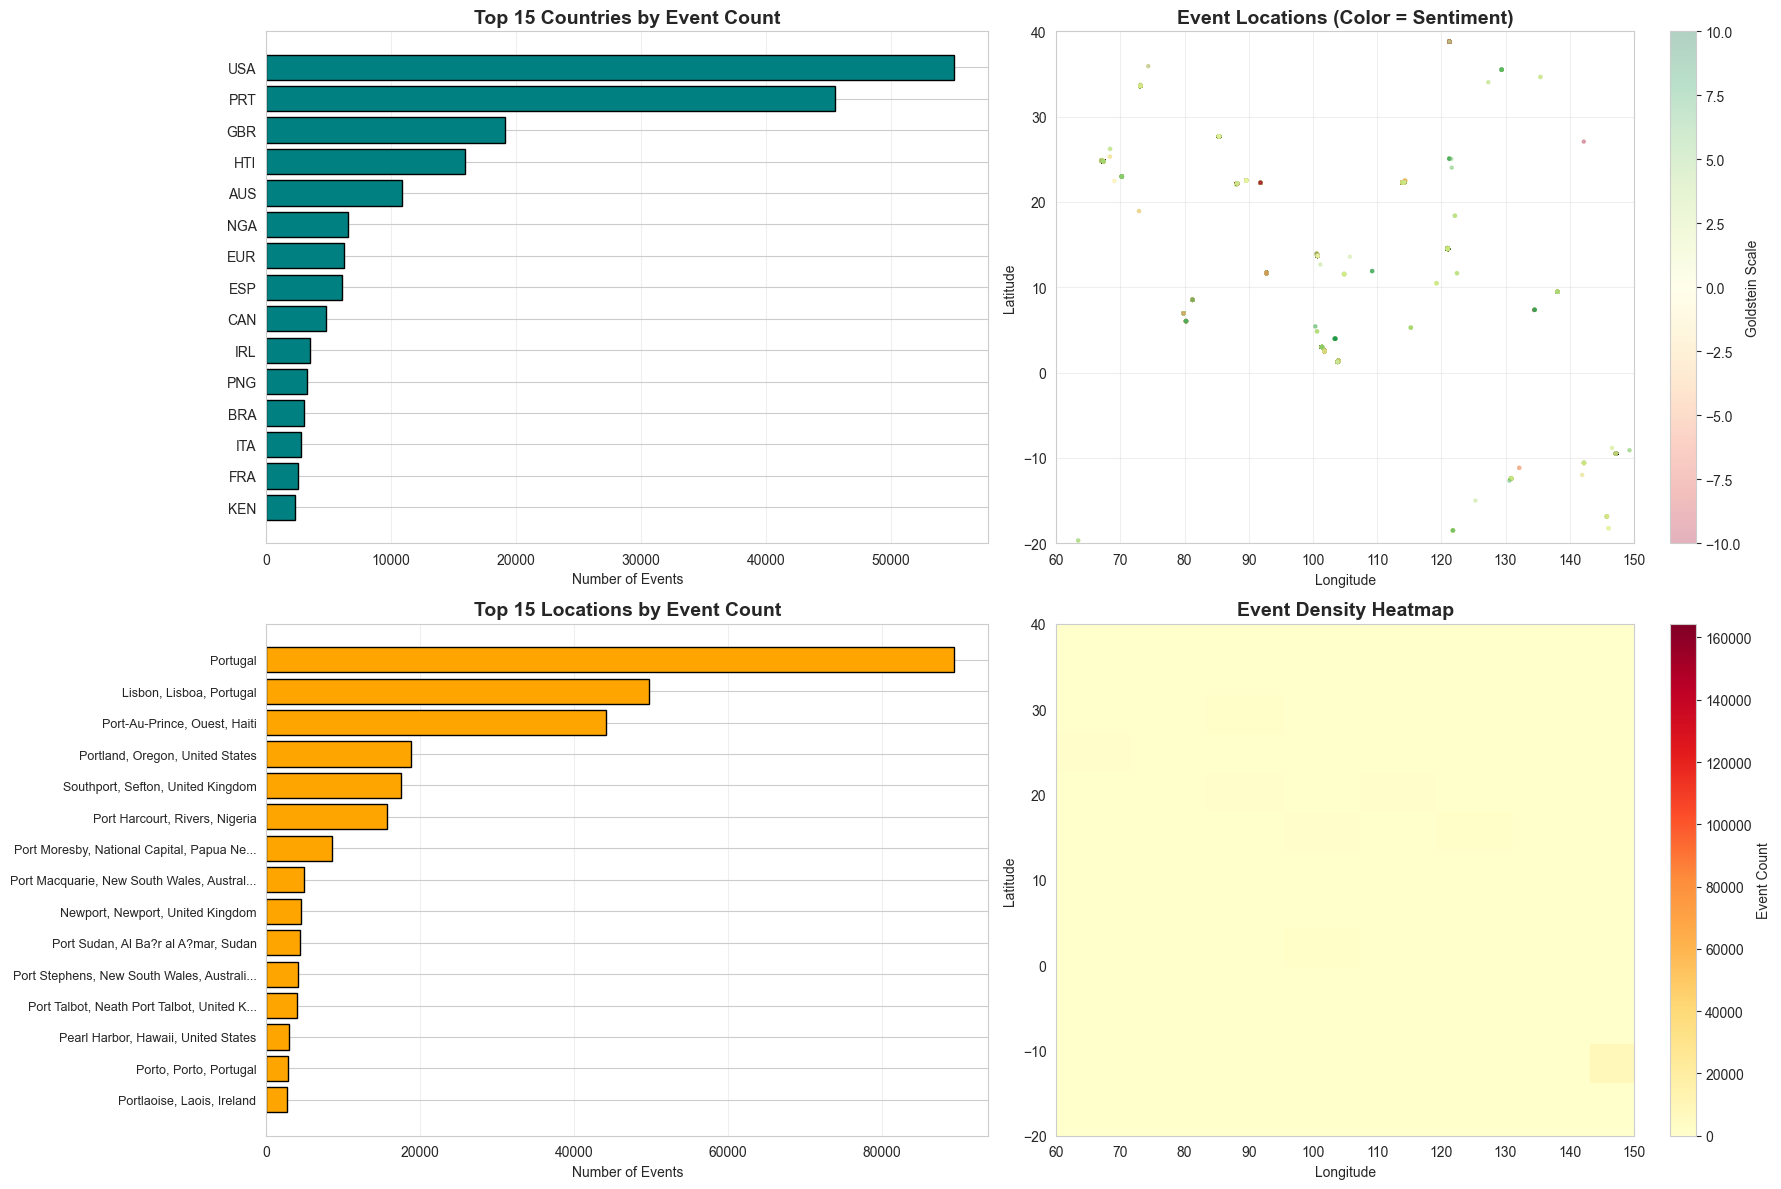


🌍 Geographic Statistics:
   Countries covered: 213
   Locations covered: 4427
   Top country: USA (55,032 events)
   Latitude range: [-54.75, 81.67]
   Longitude range: [-179.50, 178.97]

5. EVENT CHARACTERISTICS


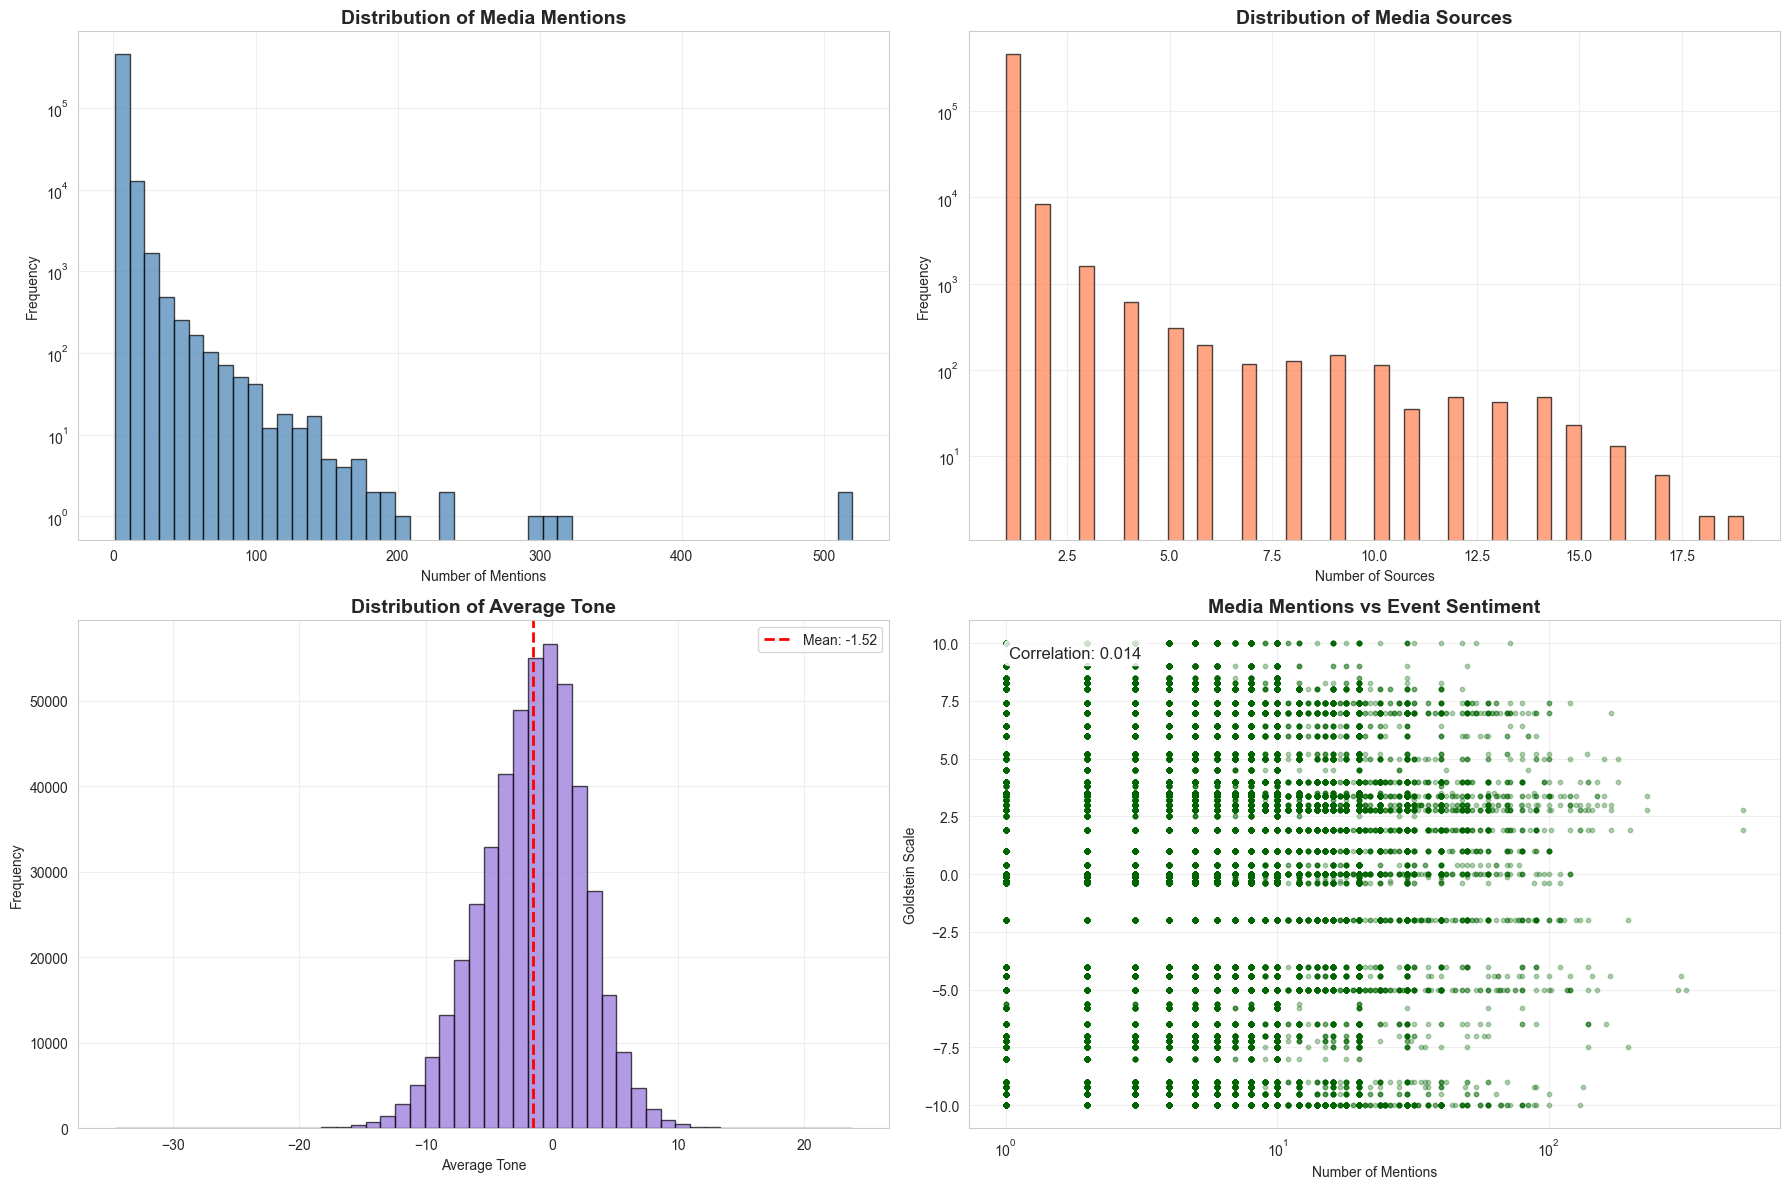


📰 Event Characteristics:
   Media Mentions - Mean: 5.9, Median: 5.0
   Media Sources - Mean: 1.0, Median: 1.0
   Average Tone - Mean: -1.52, Median: -1.22
   Correlation (Mentions vs Goldstein): 0.014

6. FEATURE CORRELATIONS


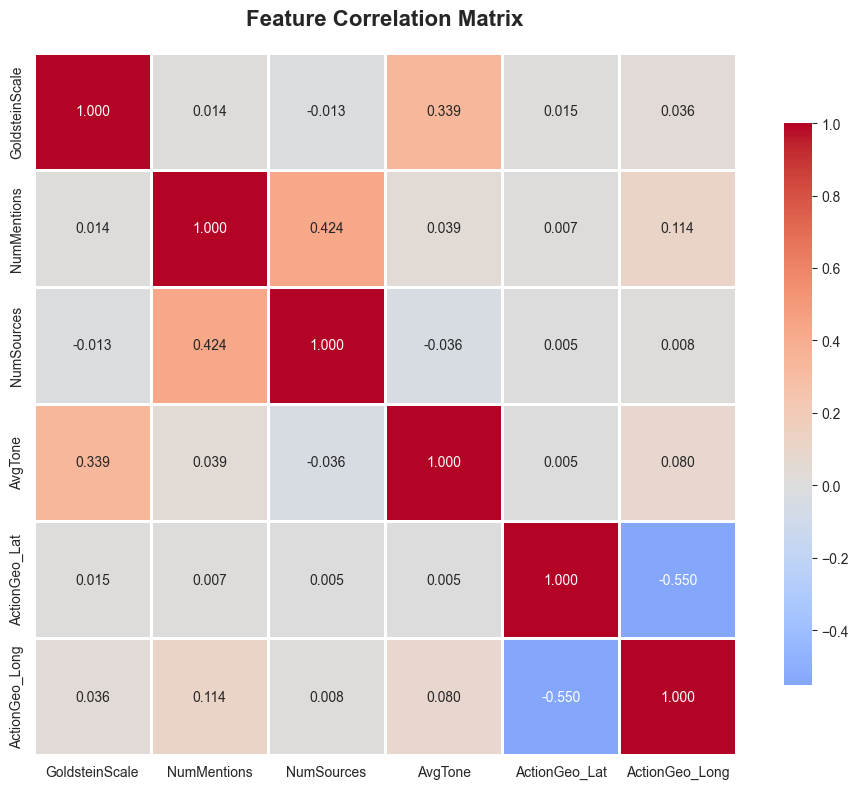


📊 Strong Correlations (|r| > 0.3):
   GoldsteinScale ↔ AvgTone: 0.339
   NumMentions ↔ NumSources: 0.424
   ActionGeo_Lat ↔ ActionGeo_Long: -0.550

✅ NEWS DATA EXPLORATION COMPLETE!

📁 All visualizations saved to: graphical analysis/news_data/
   - temporal_analysis.png
   - sentiment_analysis.png
   - geographic_analysis.png
   - event_characteristics.png
   - correlation_matrix.png


In [1]:
# ============================================================================
# DATA UNDERSTANDING: GDELT NEWS EVENTS EXPLORATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# ============================================================================
# CREATE OUTPUT FOLDER
# ============================================================================

SAMPLE_YEAR = 2024
OUTPUT_FOLDER = 'graphical analysis/news_data'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print("="*80)
print(f"GDELT NEWS DATA EXPLORATION - {SAMPLE_YEAR}")
print("="*80)
print(f"📁 Output folder: {OUTPUT_FOLDER}")

# ============================================================================
# LOAD DATA
# ============================================================================

# Load the GDELT events data
gdelt_file = f"gdelt_events_clean_{SAMPLE_YEAR}.csv"
df = pd.read_csv(gdelt_file, parse_dates=['Date'])

print(f"\n📊 Dataset Overview:")
print(f"   Total events: {len(df):,}")
print(f"   Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"   Time span: {(df['Date'].max() - df['Date'].min()).days} days")

# ============================================================================
# BASIC STATISTICS
# ============================================================================

print("\n" + "="*80)
print("1. BASIC STATISTICS")
print("="*80)

print("\n📋 Data Structure:")
print(df.info())

print("\n📊 Numerical Summary:")
print(df.describe())

print("\n🌍 Categorical Features:")
print(f"   Unique countries: {df['Actor1CountryCode'].nunique()}")
print(f"   Unique locations: {df['ActionGeo_FullName'].nunique()}")
print(f"   Unique event types: {df['EventRootCode'].nunique() if 'EventRootCode' in df.columns else 'N/A'}")

print("\n❓ Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
})
if len(missing_df) > 0:
    print(missing_df)
else:
    print("   No missing values!")

# ============================================================================
# TEMPORAL ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("2. TEMPORAL PATTERNS")
print("="*80)

# Create temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['MonthName'] = df['Date'].dt.strftime('%b')
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Quarter'] = df['Date'].dt.quarter

# Events over time
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Daily events count
daily_events = df.groupby(df['Date'].dt.date).size()
axes[0, 0].plot(daily_events.index, daily_events.values, linewidth=0.8)
axes[0, 0].set_title('Daily Event Count Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Events')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Monthly aggregation
monthly_events = df.groupby('Month').size()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 1].bar(range(1, 13), monthly_events.values, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Events by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Events')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_order[:len(monthly_events)])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Day of week pattern
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_events = df.groupby('DayOfWeek').size().reindex(day_order)
axes[1, 0].bar(range(7), dow_events.values, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Events by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Events')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Quarterly distribution
quarterly_events = df.groupby('Quarter').size()
axes[1, 1].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_events.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Events by Quarter', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Number of Events')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Temporal Statistics:")
print(f"   Busiest month: {monthly_events.idxmax()} ({monthly_events.max():,} events)")
print(f"   Quietest month: {monthly_events.idxmin()} ({monthly_events.min():,} events)")
print(f"   Busiest day: {dow_events.idxmax()} ({dow_events.max():,} events)")
print(f"   Average events/day: {daily_events.mean():.1f}")

# ============================================================================
# GOLDSTEIN SCALE ANALYSIS (Event Sentiment)
# ============================================================================

print("\n" + "="*80)
print("3. EVENT SENTIMENT ANALYSIS (GOLDSTEIN SCALE)")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Distribution of Goldstein Scale
axes[0, 0].hist(df['GoldsteinScale'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df['GoldsteinScale'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["GoldsteinScale"].mean():.2f}')
axes[0, 0].axvline(0, color='black', linestyle='-', linewidth=1, label='Neutral')
axes[0, 0].set_title('Distribution of Goldstein Scale', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Goldstein Scale')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Event categorization
def categorize_event(goldstein):
    if goldstein < -5: return 'Very Negative'
    elif goldstein < 0: return 'Negative'
    elif goldstein == 0: return 'Neutral'
    elif goldstein < 5: return 'Positive'
    else: return 'Very Positive'

df['EventCategory'] = df['GoldsteinScale'].apply(categorize_event)
category_counts = df['EventCategory'].value_counts()
category_order = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
category_counts = category_counts.reindex(category_order, fill_value=0)

colors = ['darkred', 'salmon', 'gray', 'lightblue', 'darkgreen']
axes[0, 1].bar(range(len(category_counts)), category_counts.values, color=colors, edgecolor='black')
axes[0, 1].set_title('Event Categories', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Category')
axes[0, 1].set_ylabel('Number of Events')
axes[0, 1].set_xticks(range(len(category_counts)))
axes[0, 1].set_xticklabels(category_order, rotation=15)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Goldstein scale over time
monthly_goldstein = df.groupby('Month')['GoldsteinScale'].mean()
axes[1, 0].plot(range(1, 13), monthly_goldstein.values, marker='o', linewidth=2, markersize=8, color='darkblue')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1, label='Neutral')
axes[1, 0].set_title('Average Goldstein Scale by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Goldstein Scale')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_order[:12])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot of Goldstein by quarter
sns.boxplot(data=df, x='Quarter', y='GoldsteinScale', ax=axes[1, 1], palette='Set2')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_title('Goldstein Scale Distribution by Quarter', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Goldstein Scale')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Sentiment Statistics:")
print(f"   Mean Goldstein: {df['GoldsteinScale'].mean():.3f}")
print(f"   Median Goldstein: {df['GoldsteinScale'].median():.3f}")
print(f"   Std Dev: {df['GoldsteinScale'].std():.3f}")
print(f"   Range: [{df['GoldsteinScale'].min():.2f}, {df['GoldsteinScale'].max():.2f}]")
print(f"\n   Negative events: {(df['GoldsteinScale'] < 0).sum():,} ({(df['GoldsteinScale'] < 0).mean()*100:.1f}%)")
print(f"   Neutral events: {(df['GoldsteinScale'] == 0).sum():,} ({(df['GoldsteinScale'] == 0).mean()*100:.1f}%)")
print(f"   Positive events: {(df['GoldsteinScale'] > 0).sum():,} ({(df['GoldsteinScale'] > 0).mean()*100:.1f}%)")

# ============================================================================
# GEOGRAPHIC ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("4. GEOGRAPHIC DISTRIBUTION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top countries
top_countries = df['Actor1CountryCode'].value_counts().head(15)
axes[0, 0].barh(range(len(top_countries)), top_countries.values, color='teal', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_countries)))
axes[0, 0].set_yticklabels(top_countries.index)
axes[0, 0].set_title('Top 15 Countries by Event Count', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Events')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Geographic heatmap
scatter = axes[0, 1].scatter(df['ActionGeo_Long'], df['ActionGeo_Lat'], 
                   alpha=0.3, s=5, c=df['GoldsteinScale'], cmap='RdYlGn', vmin=-10, vmax=10)
axes[0, 1].set_title('Event Locations (Color = Sentiment)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')
axes[0, 1].set_xlim(60, 150)
axes[0, 1].set_ylim(-20, 40)
axes[0, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0, 1])
cbar.set_label('Goldstein Scale')

# 3. Top locations
top_locations = df['ActionGeo_FullName'].value_counts().head(15)
axes[1, 0].barh(range(len(top_locations)), top_locations.values, color='orange', edgecolor='black')
axes[1, 0].set_yticks(range(len(top_locations)))
axes[1, 0].set_yticklabels([loc[:40] + '...' if len(loc) > 40 else loc for loc in top_locations.index], fontsize=9)
axes[1, 0].set_title('Top 15 Locations by Event Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Events')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Latitude/Longitude distribution
hist = axes[1, 1].hist2d(df['ActionGeo_Long'], df['ActionGeo_Lat'], bins=30, cmap='YlOrRd')
axes[1, 1].set_title('Event Density Heatmap', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')
axes[1, 1].set_xlim(60, 150)
axes[1, 1].set_ylim(-20, 40)
plt.colorbar(hist[3], ax=axes[1, 1], label='Event Count')

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🌍 Geographic Statistics:")
print(f"   Countries covered: {df['Actor1CountryCode'].nunique()}")
print(f"   Locations covered: {df['ActionGeo_FullName'].nunique()}")
print(f"   Top country: {top_countries.index[0]} ({top_countries.values[0]:,} events)")
print(f"   Latitude range: [{df['ActionGeo_Lat'].min():.2f}, {df['ActionGeo_Lat'].max():.2f}]")
print(f"   Longitude range: [{df['ActionGeo_Long'].min():.2f}, {df['ActionGeo_Long'].max():.2f}]")

# ============================================================================
# EVENT CHARACTERISTICS
# ============================================================================

print("\n" + "="*80)
print("5. EVENT CHARACTERISTICS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. NumMentions distribution
axes[0, 0].hist(df['NumMentions'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Media Mentions', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Mentions')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# 2. NumSources distribution
axes[0, 1].hist(df['NumSources'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Media Sources', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Sources')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. AvgTone distribution
axes[1, 0].hist(df['AvgTone'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df['AvgTone'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["AvgTone"].mean():.2f}')
axes[1, 0].set_title('Distribution of Average Tone', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Tone')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Correlation: Mentions vs Goldstein
axes[1, 1].scatter(df['NumMentions'], df['GoldsteinScale'], alpha=0.3, s=10, c='darkgreen')
axes[1, 1].set_title('Media Mentions vs Event Sentiment', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Mentions')
axes[1, 1].set_ylabel('Goldstein Scale')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)
correlation = df['NumMentions'].corr(df['GoldsteinScale'])
axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1, 1].transAxes, fontsize=12, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/event_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📰 Event Characteristics:")
print(f"   Media Mentions - Mean: {df['NumMentions'].mean():.1f}, Median: {df['NumMentions'].median():.1f}")
print(f"   Media Sources - Mean: {df['NumSources'].mean():.1f}, Median: {df['NumSources'].median():.1f}")
print(f"   Average Tone - Mean: {df['AvgTone'].mean():.2f}, Median: {df['AvgTone'].median():.2f}")
print(f"   Correlation (Mentions vs Goldstein): {correlation:.3f}")

# ============================================================================
# CORRELATION MATRIX
# ============================================================================

print("\n" + "="*80)
print("6. FEATURE CORRELATIONS")
print("="*80)

# Select numerical features for correlation
numerical_cols = ['GoldsteinScale', 'NumMentions', 'NumSources', 'AvgTone', 
                  'ActionGeo_Lat', 'ActionGeo_Long']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Strong Correlations (|r| > 0.3):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"   {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_val:.3f}")

print("\n" + "="*80)
print("✅ NEWS DATA EXPLORATION COMPLETE!")
print("="*80)
print(f"\n📁 All visualizations saved to: {OUTPUT_FOLDER}/")
print(f"   - temporal_analysis.png")
print(f"   - sentiment_analysis.png")
print(f"   - geographic_analysis.png")
print(f"   - event_characteristics.png")
print(f"   - correlation_matrix.png")